In [1]:
import os
%pwd

'c:\\Users\\Public\\Documents\\Project\\Kidney-Diseases-Classification\\research'

In [2]:
os.chdir("../")
%pwd

'c:\\Users\\Public\\Documents\\Project\\Kidney-Diseases-Classification'

In [3]:
os.environ["MLFLOW_TRACKING_URI"]="https://dagshub.com/AbhisheDATA/Kidney-Diseases-Classification.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"]="AbhisheDATA"
os.environ["MLFLOW_TRACKING_PASSWORD"]="check in mlconfig txt file"

In [4]:
import tensorflow as tf

In [5]:
model = tf.keras.models.load_model("artifacts/training/model.h5")

In [6]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class EvaluationConfig:
    path_of_model: Path
    test_data: Path
    all_params: dict
    mlflow_uri: str
    params_image_size: list
    params_batch_size: int

In [7]:
from kidney_diseases_classification.constants import *
from kidney_diseases_classification.utils.common import read_yaml, create_directories, save_json

In [10]:
class ConfigurationManager:
    def __init__(
        self, 
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])

    
    def get_evaluation_config(self) -> EvaluationConfig:
        eval_config = EvaluationConfig(
            path_of_model="artifacts/training/model.h5",
            test_data="artifacts/data_ingestion/dataset/test",
            mlflow_uri="https://dagshub.com/AbhisheDATA/Kidney-Diseases-Classification.mlflow",
            all_params=self.params,
            params_image_size=self.params.IMAGE_SIZE,
            params_batch_size=self.params.BATCH_SIZE
        )
        return eval_config

In [27]:
import tensorflow as tf
from pathlib import Path
import mlflow
import mlflow.keras
from urllib.parse import urlparse
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import classification_report
import seaborn as sns


In [28]:
class Evaluation:
    def __init__(self, config: EvaluationConfig):
        self.config = config

    
    def _valid_generator(self):
        '''  
        datagenerator_kwargs = dict(
            rescale = 1./255,
            validation_split=0.30
        )

        dataflow_kwargs = dict(
            target_size=self.config.params_image_size[:-1],
            batch_size=self.config.params_batch_size,
            interpolation="bilinear"
        )

        valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
            **datagenerator_kwargs
        )

        self.valid_generator = valid_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset="validation",
            shuffle=False,
            **dataflow_kwargs
        )

        '''
        test_datagen = ImageDataGenerator(rescale = 1/255.0,
                            rotation_range=15,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range = 0.2,
                            vertical_flip=True,
                            horizontal_flip = True,
                            fill_mode="reflect")


        self.test_generator = test_datagen.flow_from_directory(
            directory=self.config.test_data,
            target_size=self.config.params_image_size[:-1],
            class_mode='categorical',
            batch_size = self.config.params_batch_size,
            shuffle = False)



    @staticmethod
    def load_model(path: Path) -> tf.keras.Model:
        return tf.keras.models.load_model(path)
    

    def evaluation(self):
        self.model = self.load_model(self.config.path_of_model)
        self._valid_generator()
        self.score = model.evaluate(self.test_generator)
        self.save_score()

    def save_score(self):
        scores = {"loss": self.score[0], "accuracy": self.score[1]}
        save_json(path=Path("scores.json"), data=scores)
    
    
    
    def classification_report(self):
        pred = model.predict(self.test_generator)
        y_pred = np.argmax(pred, axis = 1)
        y_true = self.test_generator.classes
        print("--------------Confusion matrix--------------")
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot = True)
        print("--------------classification_report--------------")
        report = classification_report(y_true, y_pred)
        print(report)
        


    
    def log_into_mlflow(self):
        mlflow.set_registry_uri(self.config.mlflow_uri)
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        mlflow.set_experiment("experiment")

        with mlflow.start_run():
            mlflow.log_params(self.config.all_params)
            mlflow.log_metrics(
                {"loss": self.score[0], "accuracy": self.score[1]}
            )
            # Model registry does not work with file store
            if tracking_url_type_store != "file":

                #mlflow.set_experiment("VGG16Model")
                # There are other ways to use the Model Registry, which depends on the use case,
                # please refer to the doc for more information:
                # https://mlflow.org/docs/latest/model-registry.html#api-workflow
                mlflow.keras.log_model(self.model, "model", registered_model_name="InceptionV3Model")
            else:
                mlflow.keras.log_model(self.model, "model")

[2023-10-20 00:03:32,578: INFO: common: yaml file: config\config.yaml loaded successfully]
[2023-10-20 00:03:32,584: INFO: common: yaml file: params.yaml loaded successfully]
[2023-10-20 00:03:32,587: INFO: common: created directory at: artifacts]
Found 1249 images belonging to 4 classes.
20/20 [==============================] - 30s 1s/step - loss: 0.0840 - accuracy: 0.9696
[2023-10-20 00:04:06,749: INFO: common: json file saved at: scores.json]
20/20 [==============================] - 36s 2s/step
--------------Confusion matrix--------------
--------------classification_report--------------
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       372
           1       0.96      0.99      0.97       509
           2       0.96      0.83      0.89       139
           3       0.95      0.96      0.96       229

    accuracy                           0.96      1249
   macro avg       0.96      0.94      0.95      1249
weighted avg       0.9

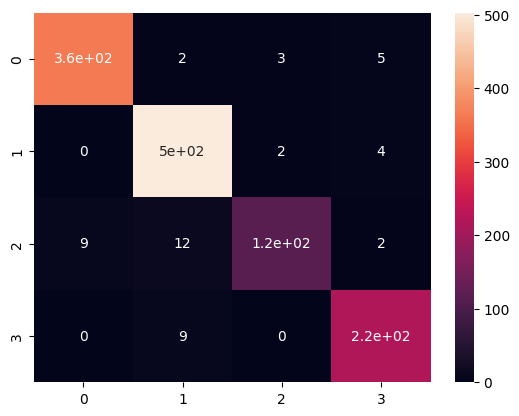

In [29]:
try:
    config = ConfigurationManager()
    eval_config = config.get_evaluation_config()
    evaluation = Evaluation(eval_config)
    evaluation.evaluation()
    evaluation.classification_report()
    #evaluation.log_into_mlflow()

except Exception as e:
   raise e